## Downloading and Importing Relevant Libraries

!pip3 install numpy --quiet
!pip3 install pandas --quiet
!pip3 install yfinance --quiet
!pip3 install matplotlib --quiet 
!pip3 install scikit-learn --quiet 
!pip3 install tensorflow --quiet

In [107]:
import yfinance as yf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

## Downloading stock data for a particular ticker and timeframe.

In [ ]:
ticker = "NVDA" 
start_date = "2019-11-25"
end_date = "2024-12-18"
nvda = yf.download(ticker, start=start_date, end=end_date)
nvda

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,,
1999-01-22,0.037615,0.041016,0.048828,0.038802,0.043750,2714688000
1999-01-25,0.041556,0.045313,0.045833,0.041016,0.044271,510480000
1999-01-26,0.038331,0.041797,0.046745,0.041146,0.045833,343200000
1999-01-27,0.038212,0.041667,0.042969,0.039583,0.041927,244368000
1999-01-28,0.038092,0.041536,0.041927,0.041276,0.041667,227520000
...,...,...,...,...,...,...
2024-12-30,137.490005,137.490005,140.270004,134.020004,134.830002,167734700
2024-12-31,134.289993,134.289993,138.070007,133.830002,138.029999,155659200


## Visualizing the closing stock price of NVDA within our set time frame.

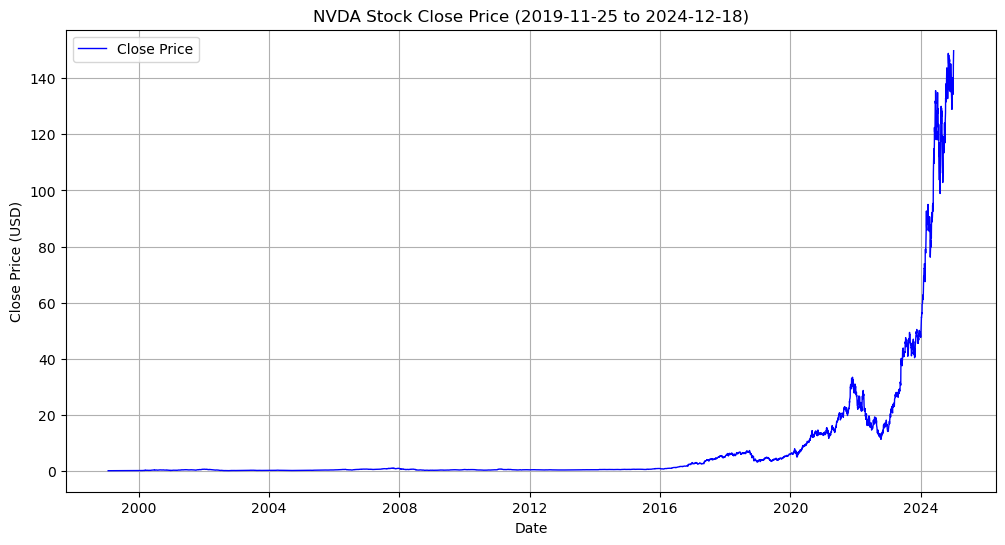

In [109]:
plt.figure(figsize=(12, 6))
plt.plot(nvda.index, nvda['Close'], color='blue', linewidth=1, label='Close Price')

# Add labels and title
plt.title(f"{ticker} Stock Close Price ({start_date} to {end_date})")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.grid(True)

## Data Preprocessing
#### LSTMs are sensitive to the scale of the data. Therefore, we need to apply the MinMax Scalar.

In [110]:
from sklearn.preprocessing import MinMaxScaler

nvda_close = nvda['Close'].values # Grabs the closing prices and stores it into a new dataframe
scaler = MinMaxScaler(feature_range=(0,1)) # Initializes the scalar that scales values from 0 to 1 
nvda_close = scaler.fit_transform(np.array(nvda_close).reshape(-1, 1)) # Applies the scalar on 'nvda_close' to scale values to between 0 and 1.

In [111]:
# Splits the data into the training and testing set in a 65-35 split.

train_val_set = nvda_close[:int(0.8 * len(nvda_close))] 
train_set = train_val_set[:int(0.8 * len(train_val_set))]
val_set = train_val_set[int(0.8 * len(train_val_set)):]
test_set = nvda_close[int(0.8 * len(nvda_close)):] 

In [112]:
def build_sequences(data, time_step):
    """Builds the time-step sequences to feed into the LSTM model."""
    X, Y = [], []
    for i in range(len(data) - time_step):
        input = data[i : i + time_step]
        target = data[i + time_step]

        X.append(input), Y.append(target)
    return np.array(X), np.array(Y)

In [113]:
time_step = 60

X_train, Y_train = build_sequences(train_set, time_step)
X_val, Y_val = build_sequences(val_set, time_step)
X_test, Y_test = build_sequences(test_set, time_step)

#### Reshaping the data because an LSTM requires a 3D input shape: (number of samples, timesteps, number of features)

In [114]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [115]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [116]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (time_step,1)))
# model.add(Dropout(0.2))  # Add dropout
model.add(LSTM(50, return_sequences=True))
# model.add(Dropout(0.2))  # Add dropout
model.add(LSTM(50))
# model.add(Dropout(0.2))  # Add dropout
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer = 'adam')

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model.fit(X_train,Y_train,validation_data=(X_val,Y_val),epochs=100, batch_size=10, verbose=1, callbacks= [early_stopping])

Epoch 1/100


412/412 ━━━━━━━━━━━━━━━━━━━━ 33s 67ms/step - loss: 8.3825e-06 - val_loss: 1.6150e-04
Epoch 2/100
412/412 ━━━━━━━━━━━━━━━━━━━━ 26s 62ms/step - loss: 3.0361e-07 - val_loss: 1.4730e-05
Epoch 3/100
412/412 ━━━━━━━━━━━━━━━━━━━━ 24s 57ms/step - loss: 1.9878e-07 - val_loss: 1.3670e-05
Epoch 4/100
412/412 ━━━━━━━━━━━━━━━━━━━━ 23s 55ms/step - loss: 1.8503e-07 - val_loss: 4.6535e-06
Epoch 5/100
412/412 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - loss: 1.3814e-07 - val_loss: 4.7727e-05
Epoch 6/100
412/412 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - loss: 2.1396e-07 - val_loss: 1.2357e-05
Epoch 7/100
412/412 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - loss: 1.1013e-07 - val_loss: 3.2055e-06
Epoch 8/100
412/412 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - loss: 1.4062e-07 - val_loss: 6.1346e-06
Epoch 9/100
412/412 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step - loss: 1.2885e-07 - val_loss: 2.7913e-06
Epoch 10/100
412/412 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - loss: 9.1423e-08 - val_loss: 5.5835e-06
Epoch 11/100
412/412 ━━━━━━━━━━━━━━━━━━━━

In [118]:
test_predict = model.predict(X_test)

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


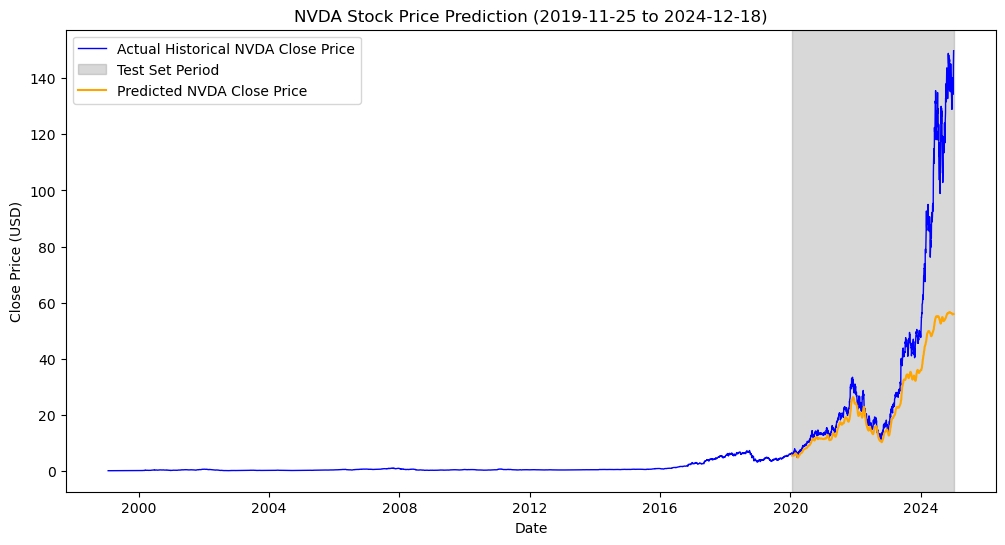

In [119]:
test_predict_actual = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform(Y_test.reshape(-1, 1))

test_dates = nvda.index[-len(y_test_actual):]

plt.figure(figsize=(12, 6))

plt.plot(nvda.index, nvda['Close'], color='blue', linewidth=1, label='Actual Historical NVDA Close Price')
plt.axvspan(test_dates[0], test_dates[-1], color='gray', alpha=0.3, label='Test Set Period')
plt.plot(test_dates, test_predict_actual, color = 'orange', label='Predicted NVDA Close Price')
plt.title(f'{ticker} Stock Price Prediction ({start_date} to {end_date})')
plt.xlabel('Date')
plt.ylabel("Close Price (USD)")
plt.legend()
plt.show()

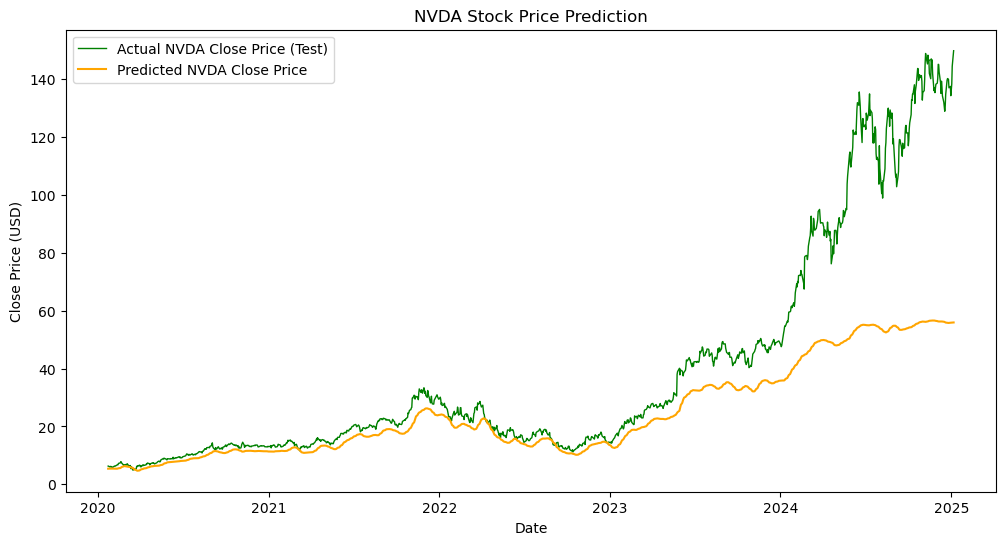

In [120]:
test_predict_actual = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform(Y_test.reshape(-1, 1))

test_dates = nvda.index[-len(y_test_actual):]

plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_actual, color='green', linewidth=1, label='Actual NVDA Close Price (Test)')
plt.plot(test_dates, test_predict_actual, color = 'orange', label='Predicted NVDA Close Price')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel("Close Price (USD)")
plt.legend()
plt.show()

In [121]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

print("Root Mean Squared Error: "+ str(root_mean_squared_error(y_test_actual, test_predict_actual)))
print("Mean Absolute Error: "+ str(mean_absolute_error(y_test_actual, test_predict_actual)))
print("R-Squared: "+ str(r2_score(y_test_actual, test_predict_actual)))
print("Mean Absolute Percentage Error: " + str(mean_absolute_percentage_error(y_test_actual, test_predict_actual)))

Root Mean Squared Error: 28.115982535553886
Mean Absolute Error: 14.920571388773853
R-Squared: 0.4687275003068563
Mean Absolute Percentage Error: 0.23741160960499424
